- (c) Ken-ichi Fukui, 2020/01/17
- MIT License

## 機器の振動データに対する異常検知
- 機密情報のため振動データは非公開になります

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import glob
import numpy as np

# フォルダ内のファイル一覧を取得
files_normal = glob.glob('../data/train/*')

# CSV形式のファイルを読み込み、学習データを全てx_trainに格納
x_train = pd.DataFrame([])
for file_name in files_normal:
    csv = pd.read_csv(filepath_or_buffer=file_name)
    x_train = pd.concat([x_train, csv])

# StandardScalerでz標準化
sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)

# データ点数と特徴数を確認
print("training data size: (#data points, #features) = (%d, %d)"% x_train.shape)

training data size: (#data points, #features) = (2926, 504)


In [9]:
# 同様にテストデータと検証用データ（ハイパーパラメータの調整用データ）の用意
files_normal  = glob.glob('../data/test/Seg_D0*')
files_anomaly1 = glob.glob('../data/test/Seg_D2*_01_*A*')
files_anomaly2 = glob.glob('../data/test/Seg_D2*_01_*B*')

# 正常データのラベルを1，異常データのラベルを-1としてテストデータ用y_test_true，検証用データ用y_valid_trueに格納
x_test_normal, x_test_anomaly1, x_test_anomaly2, x_test, x_valid = pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([])
y_test_true, y_valid_true = [], []
for file_name in files_normal:
    csv = pd.read_csv(filepath_or_buffer=file_name)
    x_test_normal = pd.concat([x_test_normal, csv])
    for i in range(0,len(csv)):
        y_test_true.append(1)
        y_valid_true.append(1)
for file_name in files_anomaly1:
    csv = pd.read_csv(filepath_or_buffer=file_name)
    x_test_anomaly1 = pd.concat([x_test_anomaly1, csv])
    for i in range(0,len(csv)):
        y_test_true.append(-1)
for file_name in files_anomaly2:
    csv = pd.read_csv(filepath_or_buffer=file_name)
    x_test_anomaly2 = pd.concat([x_test_anomaly2, csv])
    for i in range(0,len(csv)):
        y_valid_true.append(-1)

# テストデータx_test，検証用データx_validを正常データと異常データを組み合わせて用意し，z標準化
x_test = pd.concat([x_test_normal, x_test_anomaly1])
x_valid = pd.concat([x_test_normal, x_test_anomaly2])
x_test_std = sc.transform(x_test)
x_valid_std = sc.transform(x_valid)

# 正常データ数，異常データ数（テストデータ），テストデータ総数，検証用データ総数を確認
print("data size: (#normal data, #anomaly deata, #test total, #valid total) = (%d, %d, %d, %d)"% (x_test_normal.shape[0], x_test_anomaly1.shape[0], x_test.shape[0], x_valid.shape[0]))

data size: (#normal data, #anomaly deata, #test total, #valid total) = (1463, 133, 1596, 1596)


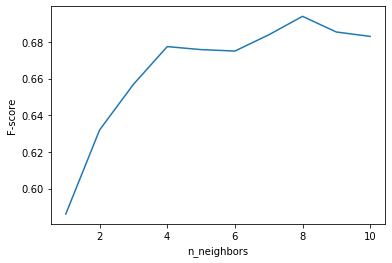

--------------------
Local Outlier Factor result (n_neighbors=8)
--------------------
Ave. Precision 0.6798, Ave. Recall 0.7967, Ave. F-score 0.7166
Confusion Matrix
   anomaly  normal
0       92      41
1      144    1319
--------------------


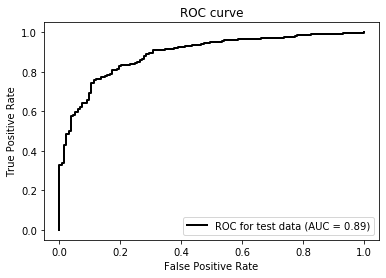

In [10]:
# Local Outlier Factor
from sklearn.neighbors import LocalOutlierFactor

# LOFの近傍数kを変化させて検証用データに対するF値を取得
idx, f_score = [], []
for k in range(1,11):
    lof = LocalOutlierFactor(n_neighbors=k, novelty=True, contamination=0.1)
    lof.fit(x_train_std)
    f_score.append(validation(y_valid_true, lof.predict(x_valid_std)))
    idx.append(k)

# F値が最大となる近傍数kを取得し，LOFに再適合
plot_fscore_graph('n_neighbors', idx, f_score)
best_k = np.argmax(f_score)+1
lof = LocalOutlierFactor(n_neighbors=best_k, novelty=True, contamination=0.1)
lof.fit(x_train_std)

# 最適な近傍数を使用して，テストデータに対する結果を表示
print("--------------------")
print("Local Outlier Factor result (n_neighbors=%d)" % best_k)
print("--------------------")
print_precision_recall_fscore(y_test_true, lof.predict(x_test_std))
print("--------------------")
print_roc_curve(y_test_true, lof.decision_function(x_test_std))

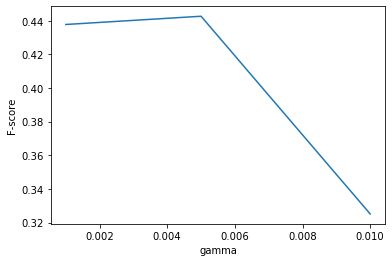

RBF kernel(best); gamma:0.0050, f-score:0.4426
Polynomial kernel(best); degree:1, gamma:0.0100, coef0:1.00, f-score:0.4244
Sigmoid kernel(best); gamma:0.0050, coef0:5.00, f-score:0.3695
--------------------
One-class SVM result
--------------------
rbf kernel
Ave. Precision 0.5596, Ave. Recall 0.6934, Ave. F-score 0.4437
Confusion Matrix
   anomaly  normal
0      120      13
1      754     709
--------------------
polynomial kernel
Ave. Precision 0.5079, Ave. Recall 0.5256, Ave. F-score 0.4244
Confusion Matrix
   anomaly  normal
0       66      67
1      651     812
--------------------
sigmoid kernel
Ave. Precision 0.4890, Ave. Recall 0.4641, Ave. F-score 0.3751
Confusion Matrix
   anomaly  normal
0       60      73
1      765     698
--------------------


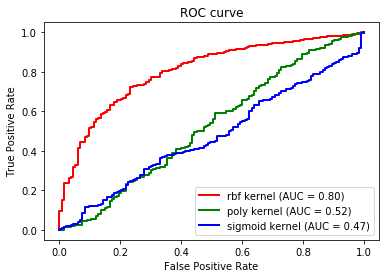

In [11]:
# One-class SVM
from sklearn.svm import OneClassSVM
import itertools

# 探索するハイパーパラメータリスト
gamma = [0.001, 0.005, 0.01]
coef0 = [0.1, 1.0, 5.0]
degree = [1, 2, 3]

# RBFカーネルのバンド幅パラメータγを変化させて検証用データに対するF値を取得
idx, f_score = [], []
for r in gamma:
    ocsvm_rbf = OneClassSVM(kernel='rbf', gamma=r)
    ocsvm_rbf.fit(x_train_std)
    f_score.append(validation(y_valid_true, ocsvm_rbf.predict(x_valid_std)))

# F値が最大となるバンド幅γを取得し，One-class SVM(RBFカーネル)に再適合
plot_fscore_graph('gamma', gamma, f_score)
best_rbf_gamma = gamma[np.argmax(f_score)]
print("RBF kernel(best); gamma:%2.4f, f-score:%.4f"% (best_rbf_gamma, np.max(f_score)))
ocsvm_rbf = OneClassSVM(kernel='rbf', gamma=best_rbf_gamma)
ocsvm_rbf.fit(x_train_std)

# 多項式カーネルのパラメータ（次数d，係数γ，定数項c）を変化させて検証用データに対するF値を取得
idx, f_score = [],[]
for d, r, c in itertools.product(degree, gamma, coef0):
    ocsvm_poly = OneClassSVM(kernel='poly', degree=d, gamma=r, coef0=c)
    ocsvm_poly.fit(x_train_std)
    f_score.append(validation(y_valid_true, ocsvm_poly.predict(x_valid_std)))
    idx.append([d,r,c])

# F値が最大となるパラメータの組合せを取得し，One-class SVM(多項式カーネル)に再適合
best_idx = idx[np.argmax(f_score)]
print("Polynomial kernel(best); degree:%1d, gamma:%.4f, coef0:%3.2f, f-score:%.4f" % (best_idx[0], best_idx[1], best_idx[2], np.max(f_score)))
ocsvm_poly = OneClassSVM(kernel='poly', degree=best_idx[0], gamma=best_idx[1], coef0=best_idx[2])
ocsvm_poly.fit(x_train_std)

# シグモイドカーネルの係数γを変化させて検証用データに対するF値を取得
idx, f_score = [],[]
for r, c in itertools.product(gamma, coef0):
    ocsvm_smd = OneClassSVM(kernel='sigmoid', gamma=r, coef0=c)
    ocsvm_smd.fit(x_train_std)
    f_score.append(validation(y_valid_true, ocsvm_smd.predict(x_valid_std)))
    idx.append([r,c])

# F値が最大となる係数γを取得し，One-class SVM(シグモイドカーネル)に再適合
best_idx = idx[np.argmax(f_score)]
print("Sigmoid kernel(best); gamma:%.4f, coef0:%2.2f, f-score:%.4f" % (best_idx[0], best_idx[1], np.max(f_score)))
ocsvm_smd = OneClassSVM(kernel='sigmoid', gamma=best_idx[0], coef0=best_idx[1])
ocsvm_smd.fit(x_train_std)

# 最適なパラメータを用いたRBFカーネル，多項式カーネル，シグモイドカーネルのテストデータに対する結果を表示
print("--------------------")
print("One-class SVM result")
print("--------------------")
print("rbf kernel")
print_precision_recall_fscore(y_test_true, ocsvm_rbf.predict(x_test_std))
print("--------------------")
print("polynomial kernel")
print_precision_recall_fscore(y_test_true, ocsvm_poly.predict(x_test_std))
print("--------------------")
print("sigmoid kernel")
print_precision_recall_fscore(y_test_true, ocsvm_smd.predict(x_test_std))
print("--------------------")
print_roc_curve_svm(y_test_true, ocsvm_rbf.decision_function(x_test_std), ocsvm_poly.decision_function(x_test_std), ocsvm_smd.decision_function(x_test_std))

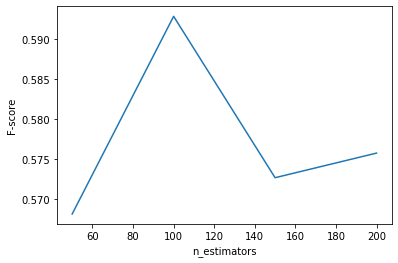

--------------------
IsolationForest result (n_estimators=100)
--------------------
Ave. Precision 0.6397, Ave. Recall 0.6900, Ave. F-score 0.6588
Confusion Matrix
   anomaly  normal
0       62      71
1      126    1337
--------------------


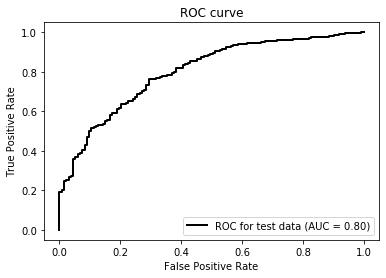

In [12]:
# IsolationForest (iForest)
from sklearn.ensemble import IsolationForest

# 探索するハイパーパラメータのリスト
estimators_params = [50, 100, 150, 200]

# アンサンブルする識別器の数n_estimatorsを変化させて検証用データに対するF値を取得
idx, f_score = [], []
for k in estimators_params:
    IF = IsolationForest(n_estimators=k, random_state=2, contamination=0.1, behaviour='new')
    IF.fit(x_train_std)
    f_score.append(validation(y_valid_true, IF.predict(x_valid_std)))
    idx.append(k)

# F値が最大となるアンサンブル数を取得し，iForestを再適合
plot_fscore_graph('n_estimators', idx, f_score)
best_k = idx[np.argmax(f_score)]
IF = IsolationForest(n_estimators=best_k, random_state=2, contamination=0.1, behaviour='new')
IF.fit(x_train_std)

# 最適なアンサンブル数を使用して，テストデータに対する結果を表示
print("--------------------")
print("IsolationForest result (n_estimators=%d)" % best_k)
print("--------------------")
print_precision_recall_fscore(y_test_true, IF.predict(x_test_std))
print("--------------------")
print_roc_curve(y_test_true, IF.decision_function(x_test_std))

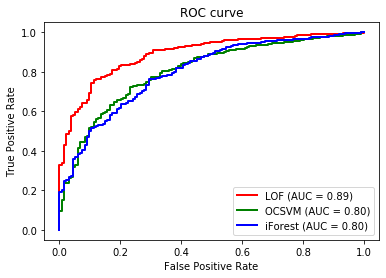

In [13]:
# LOF, SVM, iForestのROC曲線を全て表示
print_roc_curve_all(y_test_true, lof._decision_function(x_test_std), ocsvm_rbf.decision_function(x_test_std), IF.decision_function(x_test_std))

## 関数定義（先に読み込む必要あり）

In [14]:
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix

# 平均精度，平均再現率，平均F値，ならびに混同行列を表示する関数
def print_precision_recall_fscore(y_true, y_pred):
    prec_rec_f = precision_recall_fscore_support(y_true, y_pred)
    print("Ave. Precision %.4f, Ave. Recall %.4f, Ave. F-score %.4f"% (np.average(prec_rec_f[0]), np.average(prec_rec_f[1]), np.average(prec_rec_f[2])))
    print("Confusion Matrix")
    df = pd.DataFrame(confusion_matrix(y_true, y_pred))
    df.columns = [u'anomaly', u'normal']
    print(df)

In [15]:
from sklearn. metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot(plt):
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    
    plt.show()

# 正解ラベル（y_true）と識別関数の出力値（decision_function）を受け取って，ROC曲線を描画する関数
def print_roc_curve(y_true, decision_function):
    fpr, tpr, thresholds = roc_curve(y_true, decision_function, pos_label=1)
    roc_auc = roc_auc_score(y_true, decision_function)
    plt.plot(fpr, tpr, 'k--',label='ROC for test data (AUC = %0.2f)' % roc_auc, lw=2, linestyle="-")

    plot(plt)

# 同じくROC曲線を描画する関数（SVMのカーネル比較用）
def print_roc_curve_svm(y_true, decision_function_rbf, decision_function_poly, decision_function_smd):
    fpr, tpr, thresholds = roc_curve(y_true, decision_function_rbf, pos_label=1)
    roc_auc = roc_auc_score(y_true, decision_function_rbf)
    plt.plot(fpr, tpr, 'k--',label='rbf kernel (AUC = %0.2f)' % roc_auc, lw=2, linestyle="-", color="r")
    
    fpr, tpr, thresholds = roc_curve(y_true, decision_function_poly, pos_label=1)
    roc_auc = roc_auc_score(y_true, decision_function_poly)
    plt.plot(fpr, tpr, 'k--',label='poly kernel (AUC = %0.2f)' % roc_auc, lw=2, linestyle="-", color="g")
    
    fpr, tpr, thresholds = roc_curve(y_true, decision_function_smd, pos_label=1)
    roc_auc = roc_auc_score(y_true, decision_function_smd)
    plt.plot(fpr, tpr, 'k--',label='sigmoid kernel (AUC = %0.2f)' % roc_auc, lw=2, linestyle="-", color="b")

    plot(plt)

# 同じくROC曲線を描画する関数（識別器比較用）
def print_roc_curve_all(y_true, decision_function_lof, decision_function_ocsvm, decision_function_iForest):
    fpr, tpr, thresholds = roc_curve(y_true, decision_function_lof, pos_label=1)
    roc_auc = roc_auc_score(y_true, decision_function_lof)
    plt.plot(fpr, tpr, 'k--',label='LOF (AUC = %0.2f)' % roc_auc, lw=2, linestyle="-", color="r")
    
    fpr, tpr, thresholds = roc_curve(y_true, decision_function_ocsvm, pos_label=1)
    roc_auc = roc_auc_score(y_true, decision_function_ocsvm)
    plt.plot(fpr, tpr, 'k--',label='OCSVM (AUC = %0.2f)' % roc_auc, lw=2, linestyle="-", color="g")
    
    fpr, tpr, thresholds = roc_curve(y_true, decision_function_iForest, pos_label=1)
    roc_auc = roc_auc_score(y_true, decision_function_iForest)
    plt.plot(fpr, tpr, 'k--',label='iForest (AUC = %0.2f)' % roc_auc, lw=2, linestyle="-", color="b")

    plot(plt)

In [16]:
from sklearn.metrics import precision_recall_fscore_support

# 正常クラスと異常クラスに対する平均F値を返す関数
def validation(y_valid_true, y_valid_pred):
    prec_rec_f = precision_recall_fscore_support(y_valid_true, y_valid_pred)
    return np.average(prec_rec_f[2])

In [17]:
import matplotlib.pyplot as plt

# ハイパーパラメータ(idx_name)を変化させたときのF値のグラフ描画用関数
def plot_fscore_graph(idx_name, idx, f_score):
    plt.plot(idx, f_score)
    plt.xlabel(idx_name)
    plt.ylabel('F-score')
    plt.show()